In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates

In [2]:
month_day_fmt = mdates.DateFormatter('%m/%d')

In [3]:
day_df = pd.read_pickle('day.pkl')
total_df = pd.read_pickle('total.pkl')

# Folkhälsomyndigheten states that data is incomplete for last 2 days, remove those along with 'unknown data'
day_complete_df = day_df[:-3]

### Population is fetched from [SCB](http://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__BE__BE0101__BE0101A/BefolkningR1860)

In [4]:
pop_2019 = pd.read_pickle('external/pop_2019.pkl')
pop_agegroup = pop_2019.groupby('agegroup')['value'].sum()
pop_sex = pop_2019.groupby('sex')['value'].sum()

In [5]:
pop_sex

sex
kvinnor    5131775
män        5195814
Name: value, dtype: int64

In [6]:
male_per_100k = 1000 * 100 * total_df.loc[total_df.sex == 'Man', 'total_cases']/pop_sex[1]
female_per_100k = 1000 * 100 * total_df.loc[total_df.sex == 'Kvinna', 'total_cases']/pop_sex[0]
total_df.loc[total_df.sex == 'Man', 'cases_per_100k'] = male_per_100k
total_df.loc[total_df.sex == 'Kvinna', 'cases_per_100k'] = female_per_100k

In [7]:
total_df.loc[total_df.agegroup == '80-90', 'agegroup'] = '80-89'
agegroup_rows = total_df[total_df.agegroup.notna()]
age_cases_per_100k = 1000 * 100 * agegroup_rows.total_cases[:-1]/pop_agegroup.to_numpy()
age_cases_per_100k
total_df.loc[total_df.agegroup.notna(), 'cases_per_100k'] = age_cases_per_100k

In [8]:
day_complete_df = day_complete_df.assign(
    rolling_5_cases=day_df.rolling(5, min_periods=3, center=True).mean()['total_cases'],
    rolling_7_cases=day_df.rolling(7, min_periods=3, center=True).mean()['total_cases'],
)

In [9]:
print('There should be no assertion errors!\nOtherwise there is discrepancies in total data report and daily data')
assert total_df.loc[total_df['region'].notna(), 'total_cases'].sum() == day_df.total_cases.sum()
assert total_df.loc[total_df['region'].notna(), 'total_deceased'].sum() == day_df.total_deceased.sum()
assert total_df.loc[total_df['region'].notna(), 'total_icu'].sum() == day_df.total_icu.sum()

There should be no assertion errors!
Otherwise there is discrepancies in total data report and daily data


In [10]:
age_df = total_df.loc[total_df.agegroup.notna(),total_df.columns[2:]]
age_df['cases_percentage'] = age_df['cases_per_100k']/1000
age_df['deceased_percentage'] = 100 * age_df['total_deceased']/age_df['total_cases']
age_df['icu_percentage'] = 100 * age_df['total_icu']/age_df['total_cases']
age_df

,agegroup,total_cases,cases_per_100k,total_icu,total_deceased,cases_percentage,deceased_percentage,icu_percentage
0,0-9,58,4.294073,1,0,0.004294,0.000000,1.724138
1,10-19,156,13.337369,0,0,0.013337,0.000000,0.000000
2,20-29,717,52.695713,32,3,0.052696,0.418410,4.463040
3,30-39,910,67.705009,33,2,0.067705,0.219780,3.626374
4,40-49,1252,96.388585,85,4,0.096389,0.319489,6.789137
5,50-59,1687,131.295899,191,34,0.131296,2.015412,11.321873
6,60-69,1345,121.725406,224,64,0.121725,4.758364,16.654275
7,70-79,1363,144.570441,155,225,0.144570,16.507704,11.371974
8,80-89,1442,367.082711,27,352,0.367083,24.410541,1.872399
9,90+,748,956.803152,1,186,0.956803,24.866310,0.133690


In [11]:
print(f'Totalt antal smittade: {int(day_df.total_cases.sum())}')
print(f'Totalt antal dödsfall: {int(day_df.total_deceased.sum())}')
print(f'Totalt antal intensivvårdade: {int(day_df.total_icu.sum())}')
print(f'Procentuell andel positivt testade av befolkningen: {100*day_df.total_cases.sum()/pop_agegroup.sum():.3}%')
print(f'Ratio dödsfall/positivt testade: {100*day_df.total_deceased.sum()/day_df.total_cases.sum():.3}%')

Totalt antal smittade: 9685
Totalt antal dödsfall: 870
Totalt antal intensivvårdade: 749
Procentuell andel positivt testade av befolkningen: 0.0938%
Ratio dödsfall/positivt testade: 8.98%


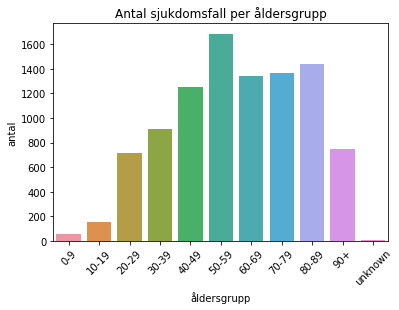

In [12]:
ax = sns.barplot('agegroup', 'total_cases', data=age_df)
ax.set_xticklabels(age_df.agegroup, rotation=45)
_ = ax.set(title='Antal sjukdomsfall per åldersgrupp', xlabel='åldersgrupp', ylabel='antal')

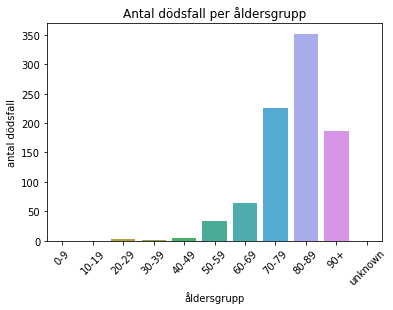

In [13]:
ax = sns.barplot('agegroup', 'total_deceased', data=age_df)
ax.set_xticklabels(age_df.agegroup, rotation=45)
_ = ax.set(title='Antal dödsfall per åldersgrupp', xlabel='åldersgrupp', ylabel='antal dödsfall')

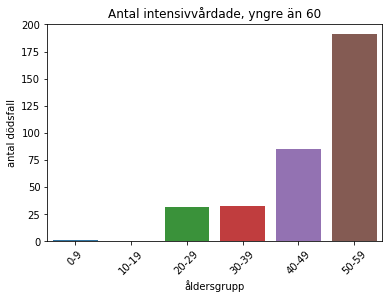

In [14]:
ax = sns.barplot('agegroup', 'total_icu', data=age_df.loc[:5])
ax.set_xticklabels(age_df.agegroup, rotation=45)
_ = ax.set(title='Antal intensivvårdade, yngre än 60', xlabel='åldersgrupp', ylabel='antal dödsfall')

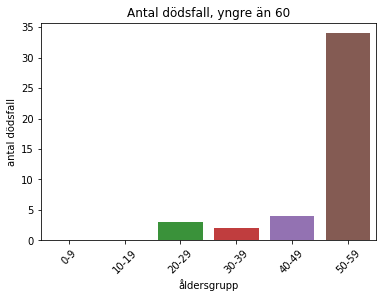

In [15]:
ax = sns.barplot('agegroup', 'total_deceased', data=age_df.loc[:5])
ax.set_xticklabels(age_df.agegroup, rotation=45)
_ = ax.set(title='Antal dödsfall, yngre än 60', xlabel='åldersgrupp', ylabel='antal dödsfall')

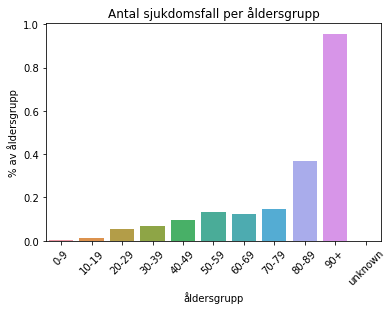

In [16]:
ax = sns.barplot('agegroup', 'cases_percentage', data=age_df)
ax.set_xticklabels(age_df.agegroup, rotation=45)
_ = ax.set(title='Antal sjukdomsfall per åldersgrupp', xlabel='åldersgrupp', ylabel='% av åldersgrupp')

In [17]:
def autolabel_above(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = int(round(rect.get_height()))
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [18]:
def autolabel_beside(rects):
    """Attach a text label to the right of each bar in *rects*, displaying its width."""
    for rect in rects:
        width = int(round(rect.get_width()))
        ax.annotate('{}'.format(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(4, -5),
                    textcoords="offset points",
                    ha='center', va='bottom')

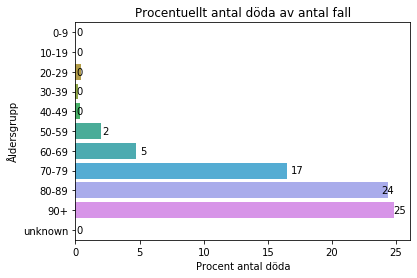

In [19]:
ax = sns.barplot('deceased_percentage', 'agegroup', data=age_df)
autolabel_beside(ax.patches)
_ = ax.set(title='Procentuellt antal döda av antal fall', xlabel='Procent antal döda', ylabel='Åldersgrupp')

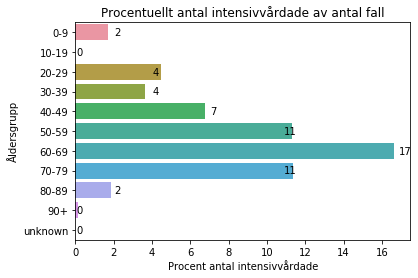

In [20]:
ax = sns.barplot('icu_percentage', 'agegroup', data=age_df)
autolabel_beside(ax.patches)
_ = ax.set(title='Procentuellt antal intensivvårdade av antal fall', xlabel='Procent antal intensivvårdade', ylabel='Åldersgrupp')

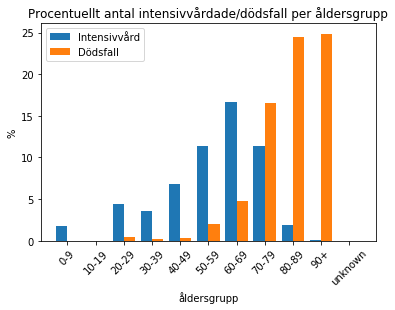

In [21]:
xpos = np.arange(len(age_df.icu_percentage))
width = .4

fig, ax = plt.subplots()
rects1 = plt.bar(xpos-width/2, age_df.icu_percentage, width, label='Intensivvård')
rects2 = plt.bar(xpos+width/2, age_df.deceased_percentage, width, label='Dödsfall')

ax.set_xticks(xpos)
ax.set_xticklabels(age_df.agegroup, rotation=45)
ax.legend()
_ = ax.set(title='Procentuellt antal intensivvårdade/dödsfall per åldersgrupp', xlabel='åldersgrupp', ylabel='%')

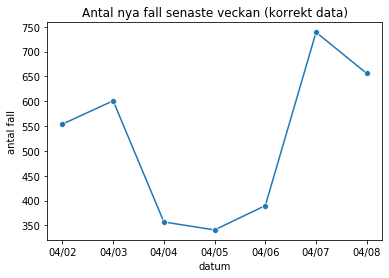

In [22]:
ax = sns.lineplot('date', 'total_cases', data=day_complete_df[-7:], marker='o')
ax.xaxis.set_major_formatter(month_day_fmt)
_ = ax.set(title='Antal nya fall senaste veckan (korrekt data)', xlabel='datum', ylabel='antal fall')

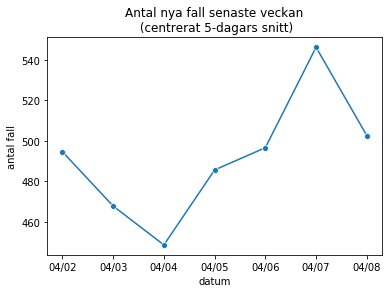

In [23]:
ax = sns.lineplot('date', 'rolling_5_cases', data=day_complete_df[-7:], marker='o')
ax.xaxis.set_major_formatter(month_day_fmt)
_ = ax.set(title='Antal nya fall senaste veckan\n (centrerat 5-dagars snitt)', xlabel='datum', ylabel='antal fall')

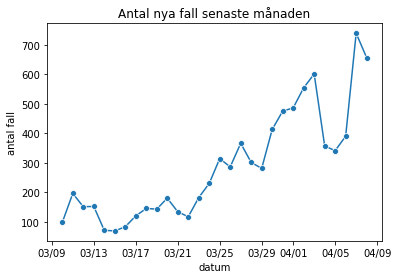

In [24]:
ax = sns.lineplot('date', 'total_cases', data=day_complete_df[-30:], marker='o')
ax.xaxis.set_major_formatter(month_day_fmt)
_ = ax.set(title='Antal nya fall senaste månaden', xlabel='datum', ylabel='antal fall')

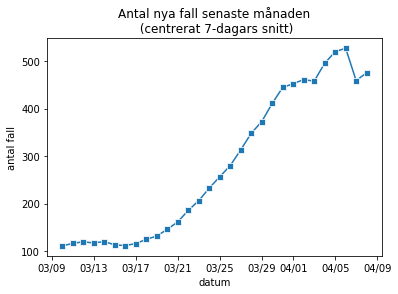

In [25]:
ax = sns.lineplot('date', 'rolling_7_cases', data=day_complete_df[-30:], marker='s')
ax.xaxis.set_major_formatter(month_day_fmt)
_ = ax.set(title='Antal nya fall senaste månaden\n (centrerat 7-dagars snitt)', xlabel='datum', ylabel='antal fall')

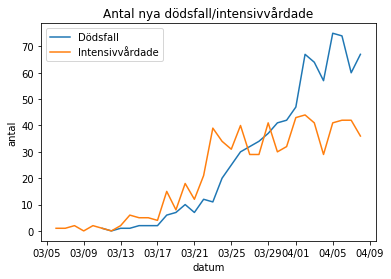

In [26]:
sns.lineplot('date', 'total_deceased', data=day_complete_df)
ax = sns.lineplot('date', 'total_icu', data=day_complete_df)
ax.xaxis.set_major_formatter(month_day_fmt)
ax.set(title='Antal nya dödsfall/intensivvårdade', xlabel='datum', ylabel='antal')
_ = ax.legend(['Dödsfall', 'Intensivvårdade'])

In [30]:
day_complete_df

,date,total_cases,Blekinge,Dalarna,Gotland,Gävleborg,Halland,Jämtland_Härjedalen,Jönköping,Kalmar,...,Västerbotten,Västernorrland,Västmanland,Västra_Götaland,Örebro,Östergötland,total_deceased,total_icu,rolling_5_cases,rolling_7_cases
0,2020-02-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.333333,0.250000
1,2020-02-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.250000,0.200000
2,2020-02-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.200000,0.166667
3,2020-02-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,0.142857
4,2020-02-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,2020-04-04,357.0,4.0,18.0,0.0,12.0,2.0,2.0,15.0,1.0,...,17.0,6.0,14.0,30.0,3.0,58.0,57.0,29.0,448.600000,495.428571
61,2020-04-05,341.0,1.0,7.0,0.0,7.0,3.0,0.0,12.0,3.0,...,9.0,2.0,7.0,30.0,0.0,41.0,75.0,41.0,485.600000,519.714286
62,2020-04-06,390.0,0.0,16.0,0.0,12.0,10.0,4.0,10.0,5.0,...,5.0,4.0,18.0,54.0,12.0,39.0,74.0,42.0,496.600000,527.000000
63,2020-04-07,739.0,1.0,28.0,0.0,16.0,13.0,5.0,23.0,4.0,...,14.0,10.0,46.0,64.0,74.0,57.0,60.0,42.0,546.200000,458.714286


# De intressantaste regionerna...

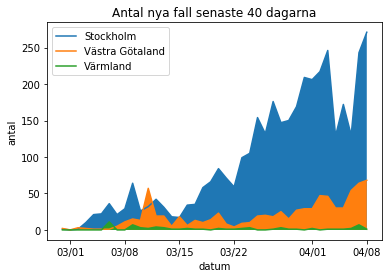

In [46]:
sns.lineplot('date', 'Stockholm', data=day_complete_df[-40:])
sns.lineplot('date', 'Västra_Götaland', data=day_complete_df[-40:])
ax = sns.lineplot('date', 'Värmland', data=day_complete_df[-40:])

ax.fill_between(day_complete_df[-40:].date, day_complete_df[-40:].rolling(['Stockholm'])
ax.fill_between(day_complete_df[-40:].date, day_complete_df[-40:]['Västra_Götaland'])
ax.fill_between(day_complete_df[-40:].date, day_complete_df[-40:]['Värmland'])

ax.xaxis.set_major_formatter(month_day_fmt)
ax.set(title='Antal nya fall senaste 40 dagarna', xlabel='datum', ylabel='antal')
_ = ax.legend(['Stockholm', 'Västra Götaland', 'Värmland'])